In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/dogs-vs-cats/test1.zip


In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from collections import OrderedDict
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

대부분의 pretrain된 모델들은 224x 224이미지를 넣는것을 요구한다. 또한 모델이 학습될 때 정규화를 사용해아한다.  
각 색상 채널을 개별적으로 정규화되고, 평균은 `[0.485, 0.456, 0.406]` 이고 표준편차는 `[0.229, 0.224, 0.225]`이다.

In [19]:
# pretrain된 모델을 다운받는다
import torchvision.models as models
model = models.resnet18(pretrained = True)
model
# gpu를 사용할 수 있으면 device를 바꾼다
device = torch.device('cuda:0' if torch.cuda.is_available()else 'cpu')

In [20]:
#!unzip ../input/dogs-vs-cats/train.zip -d train
#!unzip ../input/dogs-vs-cats/test1.zip -d test
train_dir = '../working/train/train'
test_dir = '../working/test/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [21]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import torchvision
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode = 'train', transform =None):
        self.file_list = file_list
        self.dir = dir
        self.mode = mode
        self.transform =transform
        #self.mode가 train으로 되어있고, file_list의 첫번쨰 행이 dog로 되어있으면 label 컬럼에 1을, 아니면 0
        if self.mode =='train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else :
                self.label = 0
    # file_list 데이터의 크기를 받음
    def __len__(self):
        return len(self.file_list)
    #
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx])) 
        # 한개이상의 경로 요소를 이어붙임 ex) os.path.join('c:', foo) -> (c:foo)
        if self.transform:
            img = self.transform(img)
        if self.mode =='train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else :
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),# brightness, contrast, saturation를 랜덤하게 변경 
    transforms.RandomCrop(224), # PIT이미지를 무작위 위치에서 crop, output크기는 224,224
    transforms.RandomHorizontalFlip(), # 주어진 확률만큼 horizontally filp시킴
    transforms.Resize(128),
    transforms.ToTensor()
])
    
cat_files = [tf for tf in train_files if 'cat' in tf]# (train_file의 각 행)tf에서 cat이 있으면 tf를 cat_files(리스트)에 추가
dog_files = [tf for tf in train_files if 'dog' in tf]

#data_transform에서 제시된 인자대로 cat_file의 자료들을 변형
cats =CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs =CatDogDataset(dog_files, train_dir, transform = data_transform)
#합침
catdogs = ConcatDataset([cats,dogs])

In [22]:
dataloader = DataLoader(catdogs, batch_size = 64, shuffle=True, num_workers=4)

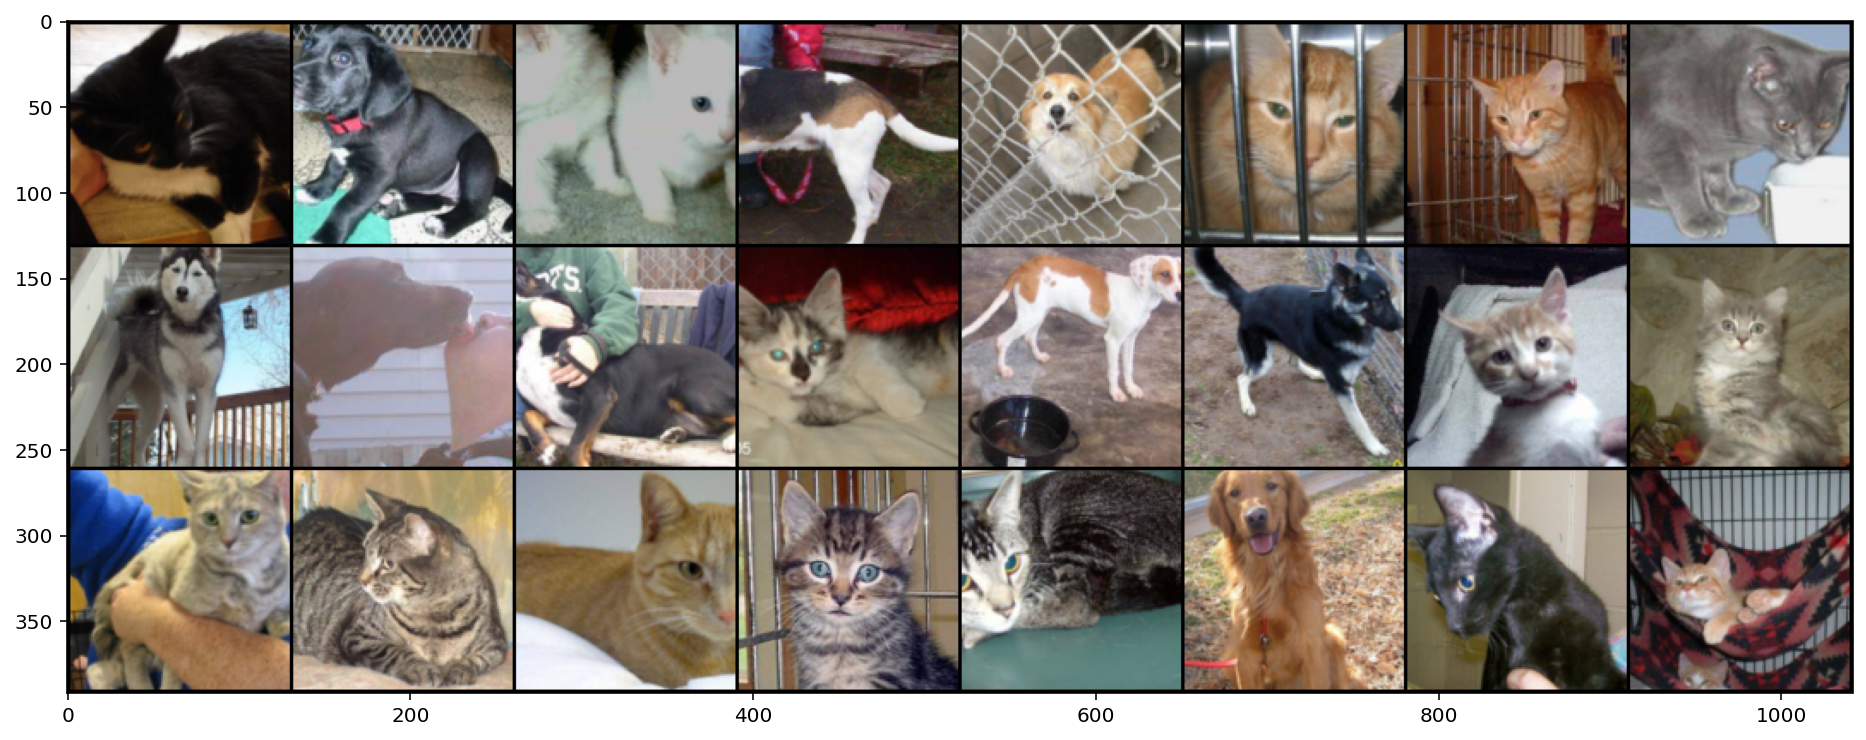

In [23]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# tensor에서 이미지는 (batch, width, height),이다. 따라서 이를 보이기 위해서 이미지를 (w,h,b)로 전치시켜야한다.
plt.imshow(np.transpose(np_grid_imgs,(1,2,0)))

## Classifier만을 위한 훈련

어떤 모델은 훈련과 평가에서 batch normalization과 같은 다른 모듈을 사용한다.  
이러한 모드를 바꾸기 위해서 `model.train()` 이나 `model.eval()`을 적절히 사용한다.

In [24]:
# parameter들을 고정
for param in model.parameters():
    param.requires_grad = False

In [25]:
import collections
OrderedDict = collections.OrderedDict()


from collections import OrderedDict

In [26]:
#resnet18의 위에 Classifier 아키텍터를 올림
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,100)),
    ('relu',nn.ReLU()),
    ('fc2', nn.Linear(100,2)),
    ('output',nn.LogSoftmax(dim=1))
]))

model.fc = fc

In [27]:
# 모델을 gpu로 변환
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 모델을 훈련시키기 위한 function
def train(model, trainloader, criterion, optimizer, epochs = 5):
    train_loss = []
    for e in range(epochs):
        running_loss =0
        for images, labels in trainloader:
            inputs, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            img = model(inputs)
            
            loss = criterion(img, labels)
            running_loss+=loss
            loss.backward()
            optimizer.step()
        print('Epoch : {}/{}..'.format(e+1,epochs),
             'Training Loss : {:.6f}'.format(running_loss/len(trainloader)))
        train_loss.append(running_loss)
    plt.plot(train_loss,label = 'Training Loss')
    plt.show()
    

epochs =3
model.train()
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
criterion = nn.NLLLoss()
train(model,dataloader, criterion, optimizer, epochs)


In [ ]:
#모델 저장
filename_pth = 'ckpt_resnet18_catdog.pth'
torch.save(model.state_dict(),filename_pth)

# 테스트 데이터셋 변환
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform =test_transform)
testloader = DataLoader(testset, batch_size = 64, shuffle=False, num_workers=4)

# Test 작업

기록을 추적하는 것(과 메모리를 사용하는 것)을 방지하기 위해, 코드 블럭을 `with torch.no_grad()`: 로 감쌀 수 있습니다. 이는 특히 변화도(gradient)는 필요없지만, requires_grad=True 가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가(evaluate)할 때 유용합니다.

In [ ]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn] # fn
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('preds_resnet18.csv', index=False)        

In [ ]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))